In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

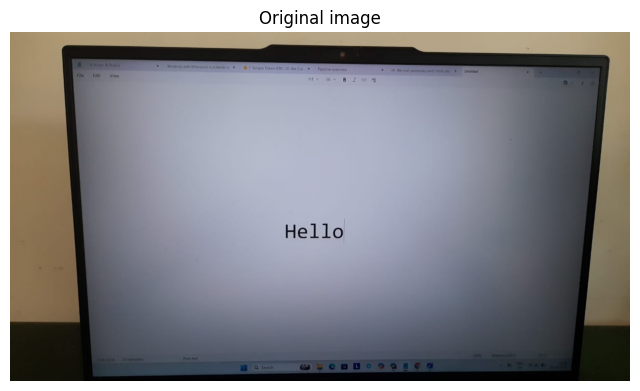

In [ ]:
img=cv2.imread('/content/IP_img3.jpeg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title("Original image")
plt.axis('off')
#plt.show()

CONVERT TO GRAY SCALE

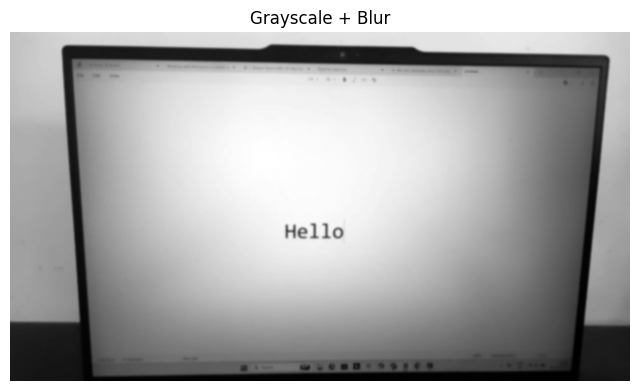

In [ ]:
gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur=cv2.GaussianBlur(gray, (11,11),0) #To reduce noise and details, with kernel size 11 x 11. Standard deviation in X diretion is calculated automatically based on kernel size by OpenCV.
plt.figure(figsize=(8,6))
plt.imshow(blur, cmap="gray")
plt.title("Grayscale + Blur")
plt.axis('off')
plt.show()


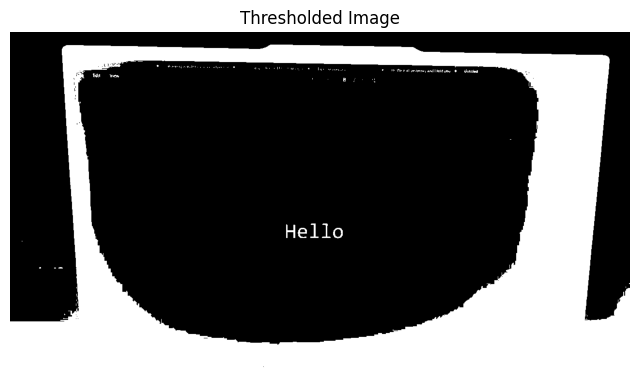

In [ ]:
_, thresh =cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#Using THRESH_OTSU automatically calculates optimal threshold value which minimizes intra-class variance
plt.figure(figsize=(8,6))
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')
plt.show()

DETECTING EDGES


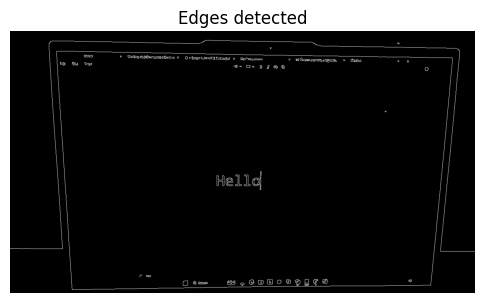

In [ ]:
edges=cv2.Canny(gray, 50,150) #Input must be in gray scale. 50: lower threshold for edge detection, 150 is the upper threshold for edge detection.
plt.figure(figsize=(6,6)) #Pixels with gradient intensity above 150 are considered strong edges.
plt.imshow(edges, cmap='gray') #Pixels with intensity between 50 and 150 are considered weak edges and are included only if connected to strong edges.
plt.title("Edges detected") #Pxels below 50 are discarded.
plt.axis('off')
plt.show()

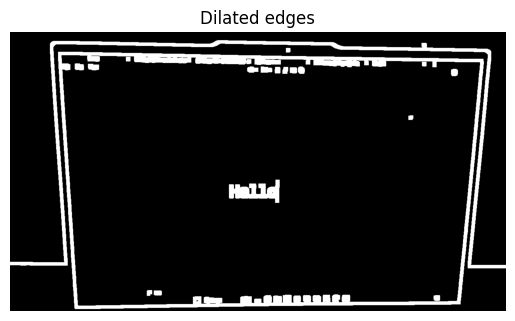

In [ ]:
kernel = np.ones((5,5), np.uint8) #Kernel is a structuring element in morphological operations like dilation
edges_dilated = cv2.dilate(edges, kernel, iterations=2)

plt.imshow(edges_dilated, cmap='gray')
plt.title("Dilated edges")
plt.axis('off')
plt.show()

In [ ]:
contours, hierarchy=cv2.findContours(edges_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours=sorted(contours, key=cv2.contourArea, reverse=True)
'''cv2.RETR_EXTERNAL tells OpenCV to retrieve only the outermost contours, ignoring inner ones,
cv2.CHAIN_APPROX_SIMPLE compresses the contour representation by removing redundant points(straight line by 2 end points)
return contours (list of contour point numpy arrays of coordinates) and heirarchy(parent child relationship between contours)
sorted sorts the contours by area from largest to smallest.
'''

'cv2.RETR_EXTERNAL tells OpenCV to retrieve only the outermost contours, ignoring inner ones,\ncv2.CHAIN_APPROX_SIMPLE compresses the contour representation by removing redundant points(straight line by 2 end points)\nreturn contours (list of contour point numpy arrays of coordinates) and heirarchy(parent child relationship between contours)\nsorted sorts the contours by area from largest to smallest.\n'

In [ ]:
for cnt in contours:
  epsilon=0.02*cv2.arcLength(cnt,True) #Epsilon is a fraction of contour perimeter, arcLength measures perimeter of contour, 0.02 means we allow 2% deviation when approximating shape, smaller epsilon, more accurate shape.
  approx=cv2.approxPolyDP(cnt,epsilon,True) #Approximates contour shape using Douglas- Peucker algorithm, simplifies contour to few points and True means contour is closed.
  if(len(approx)==4): #Douglous - Peucker algorithm is curve simplification algorithm to reduce to a fewer points.
    doc_cnt=approx
    break

APPROXIMATE TO QUADRILATERALS.


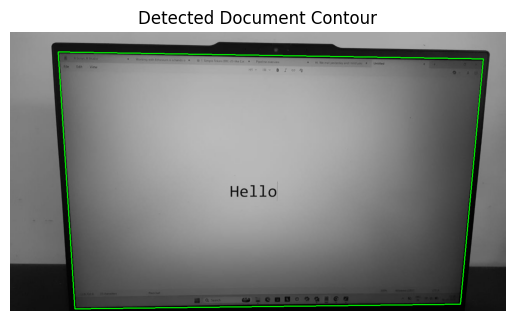

In [ ]:
gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
contour_img=cv2.drawContours(gray_bgr,[doc_cnt],-1,(0,255,0),2) #Draw a green boundary over the contour, -1 specifies draw all contours, 2 is pixel width of contour.
plt.imshow(contour_img)
plt.title("Detected Document Contour")
plt.axis('off')
plt.show()

PERSPECTIVE TRANSFORMATION

In [ ]:
def order_points(pts):
  rect=np.zeros((4,2), dtype="float32") #Creates an array of 4 points(x,y)
  pts=pts.reshape(4,2)
  s=pts.sum(axis=1) #Sum of coordinates is calculated
  rect[0]=pts[np.argmin(s)] #TL
  rect[2]=pts[np.argmax(s)] #BR
  diff=np.diff(pts,axis=1) #Find the difference between coordinates (y-x)
  rect[1]=pts[np.argmin(diff)] #TR
  rect[3]=pts[np.argmax(diff)] #BL
  return rect

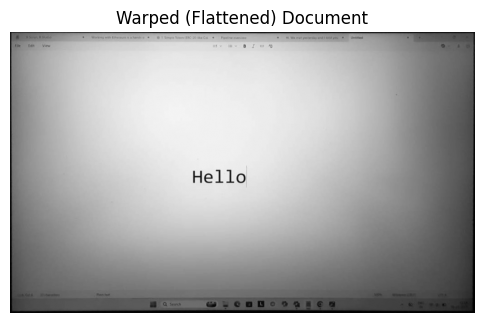

In [ ]:
rect=order_points(doc_cnt)
(tl,tr,br,bl)=rect

widthA=np.linalg.norm(br-bl)
widthB=np.linalg.norm(tr-tl)
maxWidth=max(int(widthA),int(widthB))

heightA=np.linalg.norm(tr-br)
heightB=np.linalg.norm(tl-bl)
maxHeight=max(int(heightA),int(heightB))

dst=np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]],dtype="float32")
#These are the coordinates of the output image corners.
M=cv2.getPerspectiveTransform(rect,dst) #Get transform that maps rect to dst
warped=cv2.warpPerspective(gray, M, (maxWidth, maxHeight))

plt.figure(figsize=(6,6))
plt.imshow(warped, cmap='gray')
plt.title("Warped (Flattened) Document")
plt.axis('off')
plt.show()

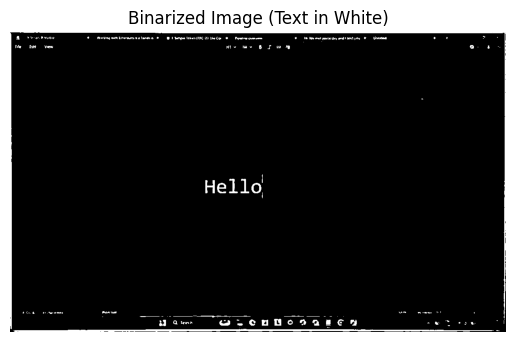

In [ ]:
img=warped.copy()
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 15, 10) # Here ADAPTIVE_THRESH_MAN_C chooses threshold value of each pixel as the mean of neighbourhood minus constant c
plt.imshow(binary, cmap='gray') #Otsu algorithm fails because of vaying illumination.
plt.title("Binarized Image (Text in White)")
plt.axis('off')
plt.show()

In [ ]:
contours, hierarchy=cv2.findContours(binary, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

char_contours=[]
for cnt in contours:
  x,y,w,h=cv2.boundingRect(cnt)
  if 1<w<200 and 15<h<200: #In this step we try to figure out characters from the image by limiting the size.
  #if w*h>0.01:
    char_contours.append((x,y,w,h))

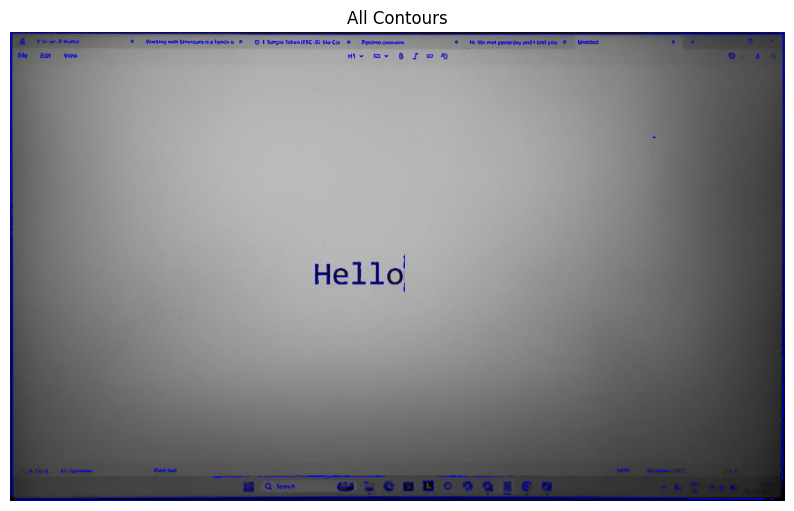

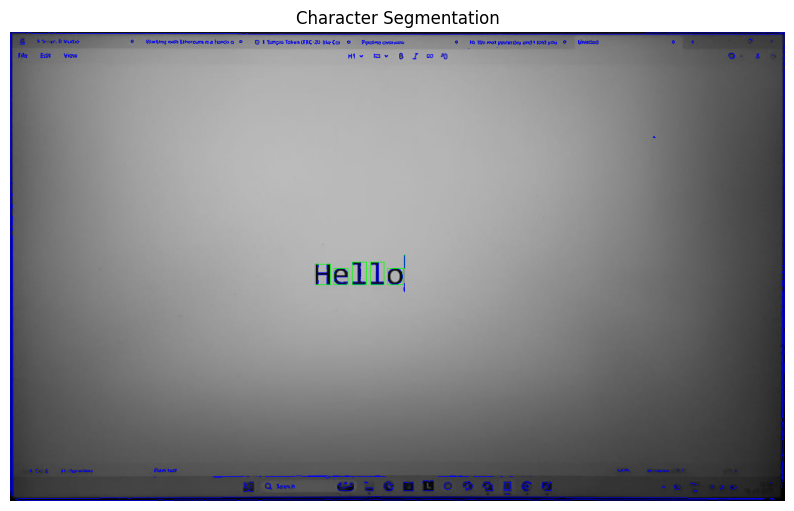

In [ ]:
char_contours=sorted(char_contours, key=lambda b: (b[1]//50,b[0])) #First sort in y direction each into bins of 50 pixels width and then in x direction.
vis=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

cv2.drawContours(vis, contours, -1, (255, 0, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(vis[..., ::-1])
plt.title("All Contours")
plt.axis('off')
plt.show()

for (x,y,w,h) in char_contours:
  cv2.rectangle(vis, (x,y),(x+w,y+h), (0,255,0),1)
plt.figure(figsize=(10,10))
plt.imshow(vis[..., ::-1]) #... represents all dimensions
plt.title("Character Segmentation")
plt.axis('off')
plt.show()

CREATING TEMPLATE IMAGES

In [ ]:
from google.colab.patches import cv2_imshow #cv2_imshow() helps to display images as cv2.imshow() is diabled in colab

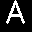

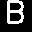

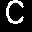

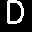

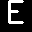

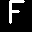

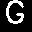

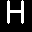

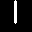

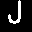

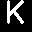

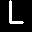

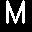

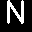

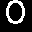

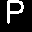

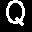

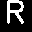

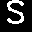

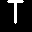

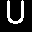

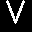

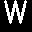

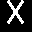

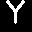

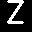

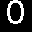

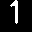

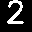

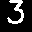

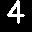

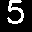

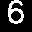

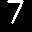

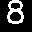

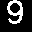

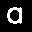

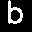

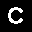

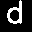

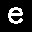

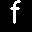

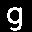

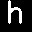

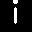

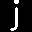

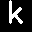

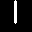

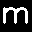

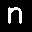

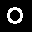

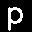

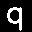

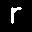

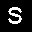

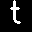

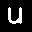

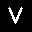

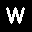

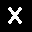

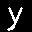

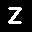

In [ ]:
characters="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789abcdefghijklmnopqrstuvwxyz"
font=cv2.FONT_HERSHEY_SIMPLEX #sans seriff font for drawing text on images
font_scale=1
thickness=2
template_size=32

templates={} #Template dictionary

for char in characters:
  img=np.ones((template_size,template_size),dtype=np.uint8)*255
  text_size,baseline=cv2.getTextSize(char,font,font_scale,thickness) #Gets text size and the baseline for long letters.
  text_x=(template_size-text_size[0])//2
  text_y=(template_size-text_size[1]-baseline)//2
  cv2.putText(img,char,(text_x,text_y+text_size[1]),font,font_scale,(0,),thickness) #Puts black text on white boxes.
  _,img_thresh=cv2.threshold(img,128,255,cv2.THRESH_BINARY_INV) #Threshold is 128 and values>128 are made white(maxVal) and less are made black.
  templates[char]=img_thresh
  cv2_imshow(img_thresh)



CHARACTER RECOGNITION

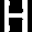

0.3587725


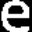

0.16185883


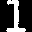

0.5777103


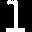

0.58525217


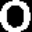

0.1023769


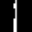

0.67638004
Recognized Text: MOjjmI


In [ ]:
recognized_text=""
for(x,y,w,h) in char_contours:
  char_img=binary[y:y+h,x:x+w]
  #char_img=warped[y:y+h,x:x+w]
  size=max(h,w)
  padded=np.ones((size,size),dtype=np.uint8)*0
  x_offset=(size-w)//2
  y_offset=(size-h)//2
  padded[y_offset:y_offset+h,x_offset:x_offset+w]=char_img
  char_img_resized=cv2.resize(padded,(template_size,template_size)) #Resize to make the image 32x32
  cv2_imshow(char_img_resized)
  best_match=None
  max_score=-1
  for char,tmpl in templates.items():
    score = cv2.matchTemplate(char_img_resized, tmpl, cv2.TM_CCOEFF_NORMED)[0][0] #Normalized cross correlation coefficient is used for template matching, [0][0] because both images are of same size
    #score=np.sum(char_img_resized==tmpl)
    if(score>max_score):
      max_score=score
      best_match=char
  recognized_text+=best_match
  print(max_score)
print("Recognized Text:", recognized_text)

In one example: 12th character is I, is correctly recognized, score>0.7 at the same time the 17th from right which is l is recognized as I because they resemble each other. All these show how unrealiable the recognition is using template based approach, it is very dependent on font style too.